## Remove red stamp in image

In [2]:
def apply_brightness_contrast(input_img, brightness = 255, contrast = 125):
    def map(x, in_min, in_max, out_min, out_max):
        return int((x-in_min) * (out_max-out_min) / (in_max-in_min) + out_min)

    brightness = map(brightness, 0, 510, -255, 255)
    contrast = map(contrast, 0, 254, -127, 127)
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    if contrast != 0:
        f = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    return buf


def qualify_bounding_boxes(bboxes):
    result_bboxes = list()
    for bbox in bboxes:
        if (bbox[0]* bbox[1] < 250):
            continue
        result_bboxes.append(bbox)
    return result_bboxes


In [9]:
import cv2
import numpy as np
from PIL import ImageEnhance, Image

def imshow(img, figsize=(25, 25), **kwargs):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(img, **kwargs)

def remove_redstamp(img_path):
    img = cv2.imread(img_path)
    copied_image = img.copy()

    img = apply_brightness_contrast(img, brightness = 255, contrast = 145)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_red_mask_1 = np.array([0,25,0], np.uint8)
    upper_red_mask_1 = np.array([10,255,255], np.uint8)
    mask1 = cv2.inRange(img_hsv, lower_red_mask_1, upper_red_mask_1)

    output_mask1 = cv2.bitwise_and(copied_image, copied_image, mask=mask1)

    lower_red_mask_2 = np.array([160,25,0])
    upper_red_mask_2 = np.array([180,255,255])
    mask2 = cv2.inRange(img_hsv, lower_red_mask_2, upper_red_mask_2)

    output_mask2 = cv2.bitwise_and(copied_image, copied_image, mask=mask2)

    output_mask = cv2.add(output_mask1, output_mask2) 
    result_image = copied_image - output_mask

    _, thresh = cv2.threshold(result_image, 5, 255, cv2.THRESH_BINARY_INV)
    opening_thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3)))
    opening_thresh_ = cv2.cvtColor(opening_thresh, cv2.COLOR_BGR2GRAY)

    contours = cv2.findContours(opening_thresh_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    result_bboxes = list()
    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)

        if (w*h >= 300):
             cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

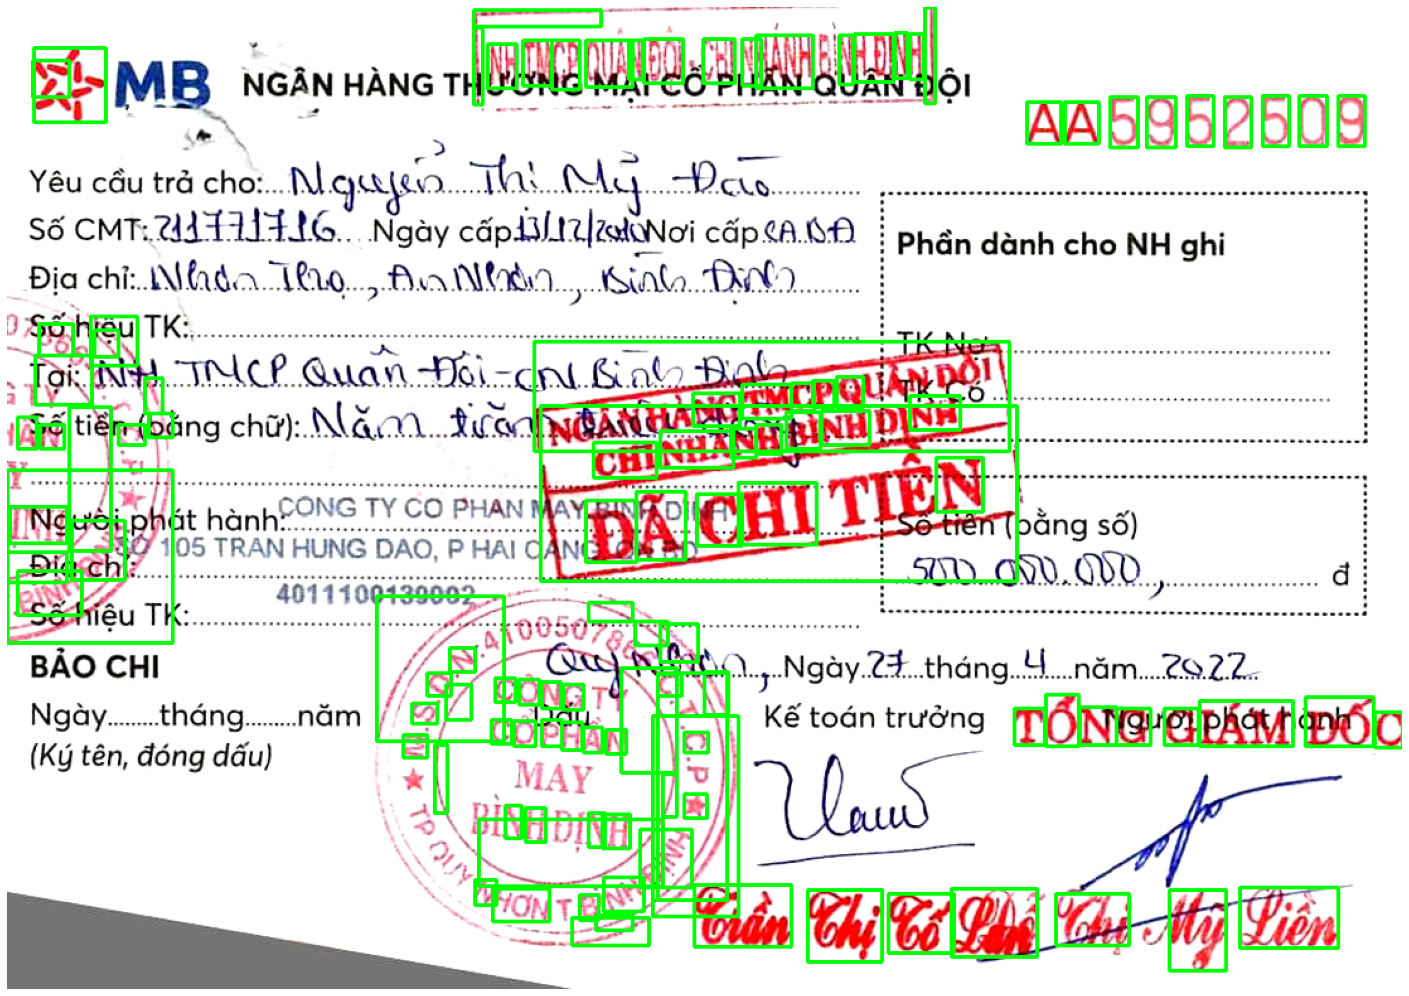

In [10]:
res = remove_redstamp(img_path = "C:/Users/ASUS/PROJECT001/data/test-repo-master/sec/sec17.jpg")
imshow(res)

## By Deep learning method

In [1]:
%cd C:/Users/ASUS/PROJECT001/stamp_processing

from stamp_processing import StampRemover
import pathlib
remover = StampRemover(detection_weight=None, removal_weight=r"C:\Users\ASUS\PROJECT001\unet_removal_weight.pkl", device='cpu')

C:\Users\ASUS\PROJECT001\stamp_processing


c:\Users\ASUS\anaconda3_2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2

preds = remover([cv2.imread("C:/Users/ASUS/PROJECT001/data/test-repo-master/sec/sec5.jpg")])

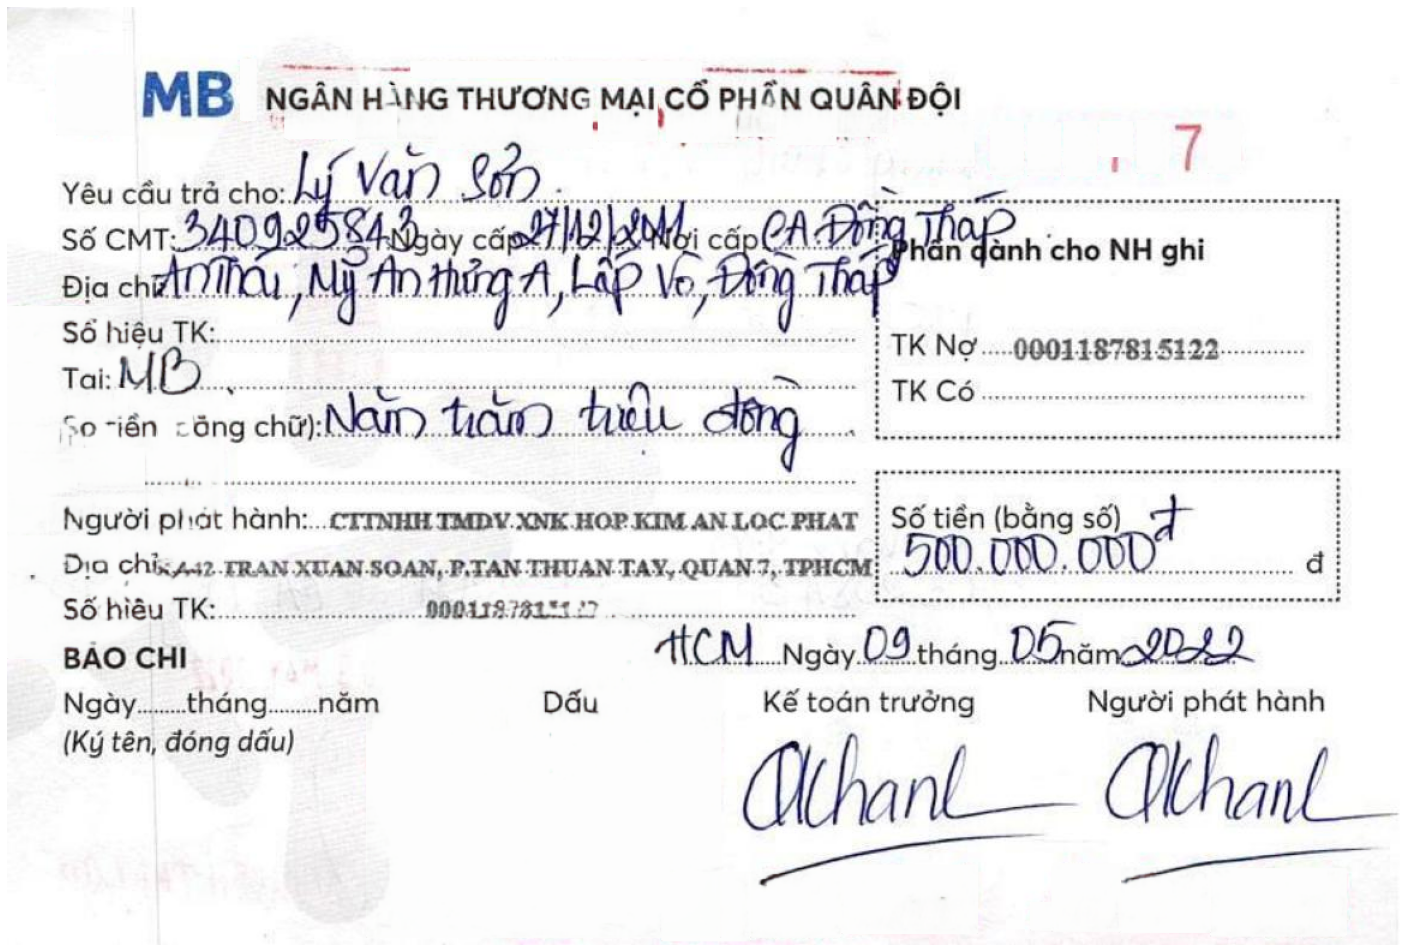

In [3]:
def imshow(img, figsize=(25, 25), **kwargs):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(img, **kwargs)


imshow(preds[0])